## Strategy

1. Split the train set in k folds [we have used [Chris Deotte](https://www.kaggle.com/cdeotte)'s TFrecords Id for spliting data]
2. Fit a first stage model on k-1 folds and predict the kth fold
3. Repeat 2) to predict each fold
4. We now have the (out-of-folds) prediction of the k folds
5. Split these out-of folds predictions in p folds
6. Fit a second stage (stacker) model on p-1 folds and predict the pth fold
7. Repeat 6) to predict each fold
8. The CV error of the second stage is calculated on each predicted fold

[reference](https://www.kaggle.com/general/18793)

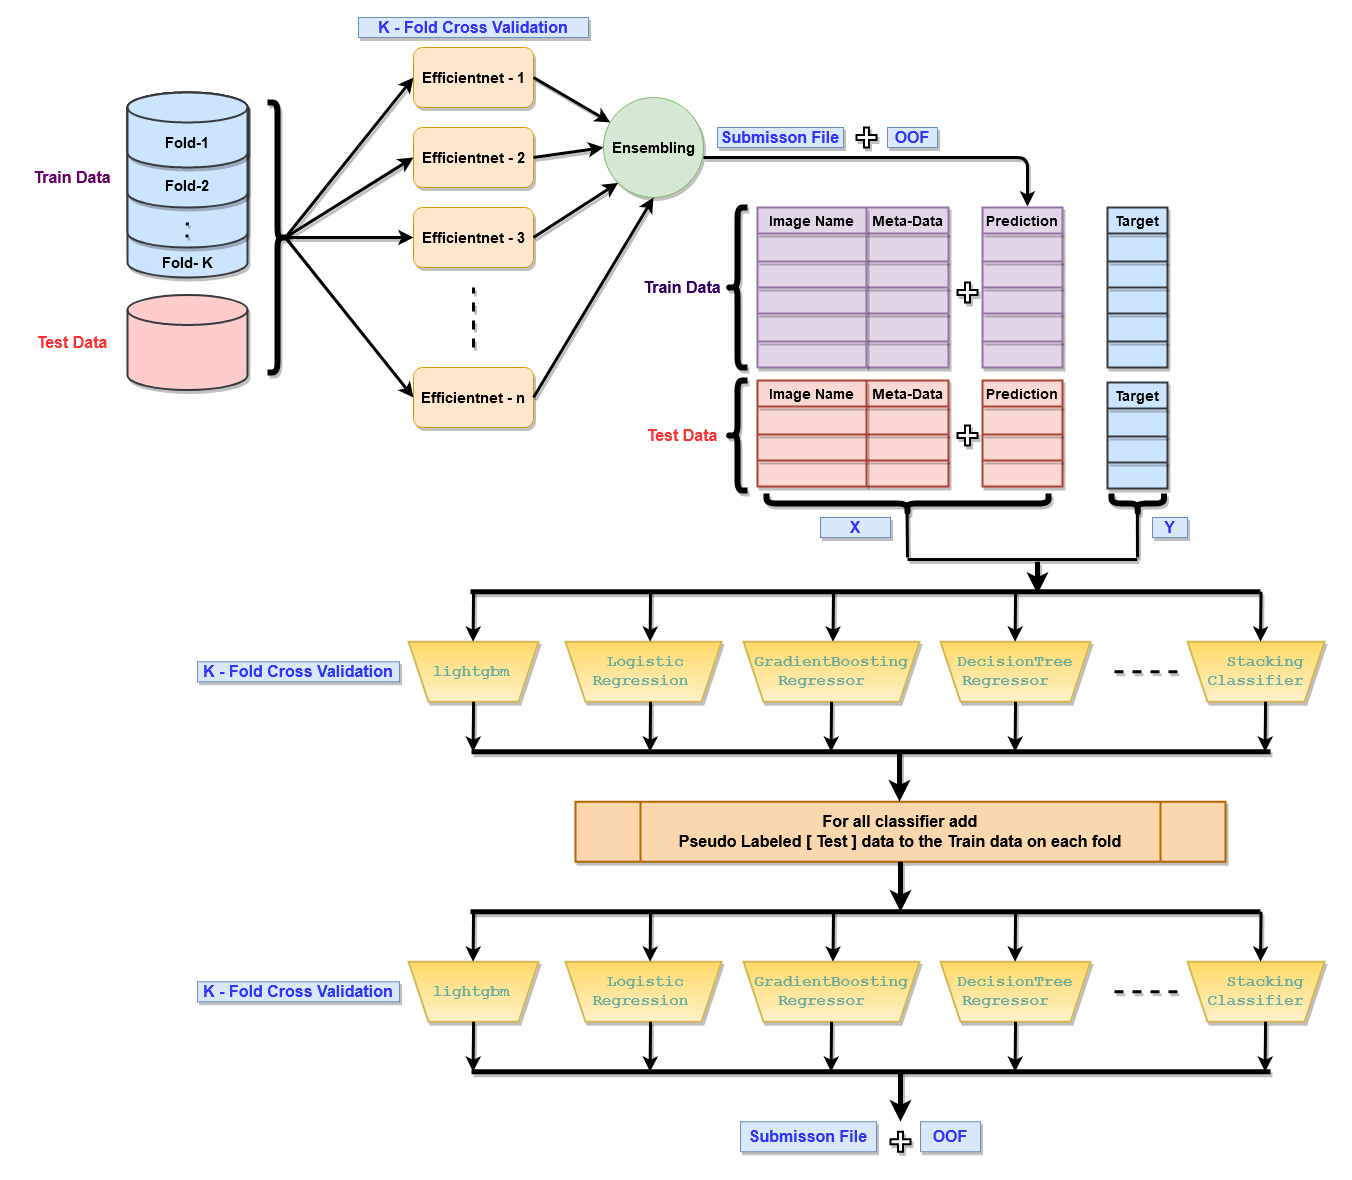

## Import Libraries

In [1]:
import re,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from colorama import Fore, Back, Style

import lightgbm as lgb # CLF1
from sklearn.linear_model import LogisticRegression # CLF2
from xgboost import XGBRegressor # CLF3
from sklearn.naive_bayes import GaussianNB  # CLF4
from sklearn.ensemble import RandomForestClassifier # CLF5
from sklearn.linear_model import LinearRegression # CLF6
from sklearn.linear_model import Lasso # CLF7
from sklearn.linear_model import ElasticNet # CLF8
from sklearn.neighbors import KNeighborsRegressor # CLF9
from sklearn.tree import DecisionTreeRegressor # CLF10
from sklearn.ensemble import GradientBoostingRegressor # CLF11
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis #CLF12
from mlxtend.classifier import StackingClassifier # SCF

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score,roc_curve

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning, module='sklearn')
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

def seed_everything(SEED):
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
FOLDS = 3
SEED = 123
Setup_Parameters = True
seed_everything(SEED)
file_add_list = [1,2,3,4,5]
pesudo_label = True
test_pipeline = True

## Import Metadata

In [3]:
BASE_PATH = '../input/siim-isic-melanoma-classification'
train_metadata = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test_metadata = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))
tfrecord_number_df =  pd.read_csv('../input/stacking-data/Image_Name_TFRecord_number.csv')

### Metadata-Size

In [4]:
print('Train data shape : ',train_metadata.shape)
print('Test data shape : ',test_metadata.shape)

Train data shape :  (33126, 8)
Test data shape :  (10982, 5)


### Metadata-values [train_metadata]

In [5]:
print('Unique values in column with frequency : ')

print('\nsex : ', dict(train_metadata.sex.value_counts()))
print('\nage_approx : ', dict(train_metadata.age_approx.value_counts()))
print('\nanatom_site_general_challenge : ', dict(train_metadata.anatom_site_general_challenge.value_counts()))
print('\ndiagnosis : ', dict(train_metadata.diagnosis.value_counts()))
print('\nbenign_malignant : ', dict(train_metadata.benign_malignant.value_counts()))
print('\ntarget : ', dict(train_metadata.target.value_counts()))

Unique values in column with frequency : 

sex :  {'male': 17080, 'female': 15981}

age_approx :  {45.0: 4466, 50.0: 4270, 55.0: 3824, 40.0: 3576, 60.0: 3240, 35.0: 2850, 65.0: 2527, 30.0: 2358, 70.0: 1968, 25.0: 1544, 75.0: 981, 20.0: 655, 80.0: 419, 85.0: 149, 15.0: 132, 90.0: 80, 10.0: 17, 0.0: 2}

anatom_site_general_challenge :  {'torso': 16845, 'lower extremity': 8417, 'upper extremity': 4983, 'head/neck': 1855, 'palms/soles': 375, 'oral/genital': 124}

diagnosis :  {'unknown': 27124, 'nevus': 5193, 'melanoma': 584, 'seborrheic keratosis': 135, 'lentigo NOS': 44, 'lichenoid keratosis': 37, 'solar lentigo': 7, 'atypical melanocytic proliferation': 1, 'cafe-au-lait macule': 1}

benign_malignant :  {'benign': 32542, 'malignant': 584}

target :  {0: 32542, 1: 584}


### Metadata-values [test_metadata]

In [6]:
print('Unique values in column with frequency : ')

print('\nsex : ', dict(test_metadata.sex.value_counts()))
print('\nage_approx : ', dict(test_metadata.age_approx.value_counts()))
print('\nanatom_site_general_challenge : ', dict(test_metadata.anatom_site_general_challenge.value_counts()))

Unique values in column with frequency : 

sex :  {'male': 6255, 'female': 4727}

age_approx :  {45.0: 1587, 40.0: 1452, 55.0: 1265, 50.0: 1230, 35.0: 1032, 60.0: 1032, 70.0: 815, 65.0: 756, 30.0: 702, 25.0: 298, 80.0: 207, 75.0: 201, 20.0: 187, 85.0: 156, 15.0: 41, 90.0: 14, 10.0: 7}

anatom_site_general_challenge :  {'torso': 5847, 'lower extremity': 2501, 'upper extremity': 1573, 'head/neck': 576, 'palms/soles': 108, 'oral/genital': 26}


## One-Hot encode Training Data

In [7]:
train = train_metadata.copy()
train['age_approx'] = train['age_approx'].fillna(train.age_approx.mean())
sex_code = pd.get_dummies(train.sex, prefix='sex')
anatom_site_general_challenge_code = pd.get_dummies(train.anatom_site_general_challenge, prefix='anatom_site')
age_aprox_normalized = (train.age_approx-train.age_approx.mean())/train.age_approx.std()
train_coded = pd.concat([train.image_name, sex_code, age_aprox_normalized, anatom_site_general_challenge_code , train.target], axis=1)
print('Shape : ',train_coded.shape)
train_coded.tail()

Shape :  (33126, 11)


,image_name,sex_female,sex_male,age_approx,anatom_site_head/neck,anatom_site_lower extremity,anatom_site_oral/genital,anatom_site_palms/soles,anatom_site_torso,anatom_site_upper extremity,target
33121,ISIC_9999134,0,1,0.078659,0,0,0,0,1,0,0
33122,ISIC_9999320,0,1,1.122821,0,0,0,0,1,0,0
33123,ISIC_9999515,0,1,-2.009664,0,1,0,0,0,0,0
33124,ISIC_9999666,0,1,0.078659,0,1,0,0,0,0,0
33125,ISIC_9999806,0,1,-0.269395,0,0,0,0,1,0,0


## Add OOF Prediction Value to Train Metadata

In [8]:
def add_OOF_pred(train_coded,num):
    for n in file_add_list:
        df_ = pd.read_csv(f'../input/95-cv-oof-submission/oof_{n}.csv')
        train_coded = pd.merge(train_coded, df_[['image_name','pred']], on="image_name",how='right')
        train_coded.rename({'pred': f'pred_{n}'}, axis=1, inplace=True)
    return train_coded
train_coded = pd.merge(tfrecord_number_df, train_coded, on="image_name",how='left')
train_coded = add_OOF_pred(train_coded,5)
train_coded.to_csv('train_coded.csv',index=False)
train_coded.tail()

,image_name,tfrecord,sex_female,sex_male,age_approx,anatom_site_head/neck,anatom_site_lower extremity,anatom_site_oral/genital,anatom_site_palms/soles,anatom_site_torso,anatom_site_upper extremity,target,pred_1,pred_2,pred_3,pred_4,pred_5
32687,ISIC_9999134,2,0,1,0.078659,0,0,0,0,1,0,0,0.013214,1.674429e-02,0.008934,3.828210e-02,0.120159
32688,ISIC_9999320,11,0,1,1.122821,0,0,0,0,1,0,0,0.000937,1.106820e-06,0.000375,1.375679e-10,0.019903
32689,ISIC_9999515,3,0,1,-2.009664,0,1,0,0,0,0,0,0.001160,4.173235e-07,0.000502,1.010386e-07,0.021704
32690,ISIC_9999666,11,0,1,0.078659,0,1,0,0,0,0,0,0.002669,1.003480e-03,0.005216,2.981703e-03,0.056021
32691,ISIC_9999806,4,0,1,-0.269395,0,0,0,0,1,0,0,0.023055,2.104348e-02,0.032791,1.837322e-01,0.173365


## One-Hot encode Testing Data

In [9]:
test = test_metadata.copy()
test['age_approx'] = test['age_approx'].fillna(test.age_approx.mean())
sex_code = pd.get_dummies(test.sex, prefix='sex')
anatom_site_general_challenge_code = pd.get_dummies(test.anatom_site_general_challenge, prefix='anatom_site')
age_aprox_normalized = (test.age_approx-test.age_approx.mean())/test.age_approx.std()
test_coded = pd.concat([test.image_name, sex_code, age_aprox_normalized , anatom_site_general_challenge_code], axis=1)
print('Shape : ',test_coded.shape)
test_coded.tail()

Shape :  (10982, 10)


,image_name,sex_female,sex_male,age_approx,anatom_site_head/neck,anatom_site_lower extremity,anatom_site_oral/genital,anatom_site_palms/soles,anatom_site_torso,anatom_site_upper extremity
10977,ISIC_9992485,0,1,-0.662853,0,0,0,0,1,0
10978,ISIC_9996992,0,1,-1.010786,0,0,0,0,1,0
10979,ISIC_9997917,0,1,-1.706652,0,0,0,0,0,1
10980,ISIC_9998234,0,1,1.076811,0,1,0,0,0,0
10981,ISIC_9999302,0,1,-1.358719,0,0,0,0,0,1


## Add Submission Target Value to Test Metadata

In [10]:
def add_submission_pred(test_coded,num):
    for n in file_add_list:
        df_ = pd.read_csv(f'../input/95-cv-oof-submission/submission_{n}.csv')
        test_coded = pd.merge(test_coded, df_[['image_name','target']], on="image_name",how='right')
        test_coded.rename({'target': f'pred_{n}'}, axis=1, inplace=True)
    return test_coded
test_coded = add_submission_pred(test_coded,5)
test_coded.to_csv('test_coded.csv',index=False)
test_coded.tail()

,image_name,sex_female,sex_male,age_approx,anatom_site_head/neck,anatom_site_lower extremity,anatom_site_oral/genital,anatom_site_palms/soles,anatom_site_torso,anatom_site_upper extremity,pred_1,pred_2,pred_3,pred_4,pred_5
10977,ISIC_9992485,0,1,-0.662853,0,0,0,0,1,0,0.000968,0.000108,0.000243,3.511394e-05,0.052316
10978,ISIC_9996992,0,1,-1.010786,0,0,0,0,1,0,0.011886,0.017020,0.000682,3.613343e-02,0.125994
10979,ISIC_9997917,0,1,-1.706652,0,0,0,0,0,1,0.040804,0.050703,0.000969,1.127292e-01,0.171867
10980,ISIC_9998234,0,1,1.076811,0,1,0,0,0,0,0.000985,0.000002,0.000127,4.122612e-09,0.013552
10981,ISIC_9999302,0,1,-1.358719,0,0,0,0,0,1,0.087687,0.153389,0.010256,5.238238e-01,0.285668


In [11]:
def crossValidate(CLF,X=train_coded,X_test=test_coded,FOLDS = 5,SEED = 123,show_roc_curve = False,pesudo_label = False):
    print(Fore.YELLOW)
    print('#'*60)
    model_name = type(CLF).__name__
    print('#### ',model_name)
    print('#'*60,Style.RESET_ALL)
    
    CV_Score = []
    Val_preds = []
    Val_imagenames = []
    val_targets = []
    
    CV_Score_pesudo = []
    Val_preds_pesudo = []
    Val_imagenames_pesudo = []
    val_targets_pesudo = []
    
    skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

    for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):

        idxT, idxV = X.tfrecord.isin(idxT), X.tfrecord.isin(idxV)

        X_train_main, y_train_main = X[idxT], X[idxT]
        X_val_main, y_val_main = X[idxV], X[idxV]
        print(Fore.MAGENTA)
        print('#'*60,Style.RESET_ALL)
        print(Fore.BLUE)
        print('FOLD : ',fold)
        print('Train TFrecords : ',X_train_main.tfrecord.unique())
        print('Validation TFrecords : ',X_val_main.tfrecord.unique())
        image_names = list(X_val_main['image_name'])
        
        X_train = X_train_main.drop(['target','tfrecord'],axis=1).iloc[:,1:]
        y_train = y_train_main['target']
        
        X_val = X_val_main.drop(['target','tfrecord'],axis=1).iloc[:,1:]
        y_val = y_val_main['target']
        
        CLF_pesudo = CLF
        CLF.fit(X_train, y_train)
        
        try:
            y_train_pred  = CLF.predict_proba(X_train)[:,1]
        except:
            y_train_pred = CLF.predict(X_train)
            
        print('Train AUC : ', roc_auc_score(y_train,y_train_pred))
        try:
            Val_pred  = CLF.predict_proba(X_val)[:,1]
        except:
            Val_pred = CLF.predict(X_val)
            
        Val_auc = roc_auc_score(y_val,Val_pred)
        print('Val AUC : ', Val_auc)
        
        CV_Score.append(Val_auc)
        Val_preds.append(Val_pred)
        Val_imagenames.append(image_names)
        val_targets.append(list(y_val))
        
        if pesudo_label:
            
            train2_Pesudo = X_train_main.copy()
            train2_Pesudo['target_label'] = y_train_main['target']
            test2_Pesudo = X_val_main.copy()
            test2_Pesudo['target_label'] = Val_pred
            
            test2_Pesudo = test2_Pesudo[ (test2_Pesudo['target_label'] >= 0.99) |  
                                            (test2_Pesudo['target_label'] >= 0.01)]
            test2_Pesudo.loc[ test2_Pesudo['target_label']>=0.5, 'target_label' ] = 1
            test2_Pesudo.loc[ test2_Pesudo['target_label']<0.5, 'target_label' ] = 0
            
            print(Fore.CYAN)
            print('Number of Pesudo Labeled Data added : ',len(test2_Pesudo))
            print('target_label = 1 : ',len(test2_Pesudo[test2_Pesudo['target_label'] == 1]))
            print('target_label = 0 : ',len(test2_Pesudo[test2_Pesudo['target_label'] == 0]))
            
            train_pesudo = pd.concat([train2_Pesudo,test2_Pesudo],axis=0)
            
            X_train_pesudo = train_pesudo.drop(['target_label','target','tfrecord'],axis=1).iloc[:,1:]
            y_train_pesudo = train_pesudo['target_label']
            
            CLF_pesudo.fit(X_train_pesudo, y_train_pesudo)
            
            try:
                y_train_pred_pesudo  = CLF_pesudo.predict_proba(X_train_pesudo)[:,1]
            except:
                y_train_pred_pesudo = CLF_pesudo.predict(X_train_pesudo)

            print('Pesudo Train AUC : ', roc_auc_score(y_train_pesudo,y_train_pred_pesudo))
            try:
                Val_pred_pesudo  = CLF_pesudo.predict_proba(X_val)[:,1]
            except:
                Val_pred_pesudo = CLF_pesudo.predict(X_val)
            
            Val_auc_pesudo = roc_auc_score(y_val,Val_pred_pesudo)
            print('Pesudo Val AUC : ', Val_auc_pesudo)
            print(Style.RESET_ALL)
            
            CV_Score_pesudo.append(Val_auc_pesudo)
            Val_preds_pesudo.append(Val_pred_pesudo)
            Val_imagenames_pesudo.append(image_names)
            val_targets_pesudo.append(list(y_val))
            
    valtargets = np.concatenate(val_targets)
    valpreds = np.concatenate(Val_preds)
    valimagenames = np.concatenate(Val_imagenames)
    
    auc_score = roc_auc_score(valtargets,valpreds)
    
    print(Fore.YELLOW)
    print('#'*60)
    print('\nCV(auc_score) : ',auc_score)
    print(f'Mean CV : {np.mean(CV_Score)} +/- {np.std(CV_Score)}\n')
    
    
    oof = pd.DataFrame()
    oof['image_name'] = valimagenames
    oof['pred'] = valpreds
    oof['target'] = valtargets
    
    
    ## Test data Prediction
    Test_imagenames = X_test['image_name']
    X_test = X_test.iloc[:,1:]
    try:
        test_pred = CLF.predict_proba(X_test)[:,1]
    except:
        test_pred = CLF.predict(X_test)
        
    submission = pd.DataFrame()
    submission['image_name'] = Test_imagenames
    submission['target'] = test_pred
    
    if pesudo_label:
        valtargets_pesudo = np.concatenate(val_targets_pesudo)
        valpreds_pesudo = np.concatenate(Val_preds_pesudo)
        valimagenames_pesudo = np.concatenate(Val_imagenames_pesudo)
        
        auc_score_pesudo = roc_auc_score(valtargets_pesudo,valpreds_pesudo)
        
        print('Pesudo CV(auc_score) : ',auc_score_pesudo)
        print(f'Pesudo Mean CV : {np.mean(CV_Score_pesudo)} +/- {np.std(CV_Score_pesudo)}\n')
        
        oof_pesudo = pd.DataFrame()
        oof_pesudo['image_name'] = valimagenames_pesudo
        oof_pesudo['pred'] = valpreds_pesudo
        oof_pesudo['target'] = valtargets_pesudo
        
        ## Test data Prediction (Pesudo)
        try:
            test_pred_pesudo = CLF_pesudo.predict_proba(X_test)[:,1]
        except:
            test_pred_pesudo = CLF_pesudo.predict(X_test)

        submission_pesudo = pd.DataFrame()
        submission_pesudo['image_name'] = Test_imagenames
        submission_pesudo['target'] = test_pred_pesudo
        
    
    print('#'*60,Style.RESET_ALL)
    if show_roc_curve:
        fpr, tpr, _ = roc_curve(valtargets,valpreds)
        if pesudo_label:
            fpr_p, tpr_p, _ = roc_curve(valtargets_pesudo,valpreds_pesudo)
            
        plt.figure()
        lw = 2
        if pesudo_label:
            plt.plot(fpr_p, tpr_p, color='red',
                 lw=lw, label=f'Pesudo ROC curve (area = {auc_score_pesudo:0.4f})')
            
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label=f'ROC curve (area = {auc_score:0.4f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve by : {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    
    if pesudo_label:
        return oof , submission, auc_score, model_name, oof_pesudo, submission_pesudo, auc_score_pesudo, str(model_name) + '_Pesudo'
    return oof , submission, auc_score, model_name

# **Classifiers**

## LGBMClassifier

In [12]:
clf1 = lgb.LGBMClassifier(max_depth=5, 
                          metric="auc", 
                          n_estimators=100, 
                          num_leaves=5, 
                          boosting_type="gbdt", 
                          learning_rate=0.1, 
                          feature_fraction=0.05, 
                          colsample_bytree=0.1, 
                          bagging_fraction=0.8, 
                          bagging_freq=2, 
                          reg_lambda=0.2)

## LogisticRegression

In [13]:
clf2 = LogisticRegression(
            C= 1.0,
            class_weight=None,
            dual= False,
            fit_intercept= True,
            intercept_scaling= 1,
            l1_ratio= None,
            max_iter= 100,
            multi_class= 'auto',
            n_jobs= None,
            penalty= 'l2',
            random_state= None,
            solver= 'lbfgs',
            tol= 0.0001,
            verbose= 0,
            warm_start= False)

## XGBRegressor

In [14]:
clf3 = XGBRegressor(base_score=0.5, 
                    booster=None, 
                    colsample_bylevel=1,
                    colsample_bynode=1, 
                    colsample_bytree=0.8, 
                    gamma=1, 
                    gpu_id=-1,
                    importance_type='gain', 
                    interaction_constraints=None,
                    learning_rate=0.002, 
                    max_delta_step=0, 
                    max_depth=10,
                    min_child_weight=1, 
                    missing=None, 
                    monotone_constraints=None,
                    n_estimators=700, 
                    n_jobs=-1, 
                    nthread=-1, 
                    num_parallel_tree=1,
                    objective='binary:logistic', 
                    random_state=0,
                    reg_alpha=0, 
                    reg_lambda=1, 
                    scale_pos_weight=1,
                    subsample=0.8,
                    tree_method=None, 
                    validate_parameters=False, 
                    verbosity=None)

## GaussianNB

In [15]:
clf4 = GaussianNB(
    priors= None, 
    var_smoothing= 1e-09)

## RandomForestClassifier

In [16]:
clf5 = RandomForestClassifier(
        bootstrap= True,
        ccp_alpha= 0.0,
        class_weight= None,
        criterion= 'gini',
        max_depth= 5,
        max_features= 'auto',
        max_leaf_nodes= 30,
        max_samples= None,
        min_impurity_decrease= 0.0,
        min_impurity_split= None,
        min_samples_leaf= 2,
        min_samples_split= 100,
        min_weight_fraction_leaf= 0.0,
        n_estimators= 300,
        n_jobs= None,
        oob_score= False,
        random_state= None,
        verbose= 0,
        warm_start= False)

## LinearRegression

In [17]:
# clf6 = LinearRegression()

## Lasso

In [18]:
# clf7 = Lasso()

## ElasticNet

In [19]:
# clf8 = ElasticNet()

## KNeighborsRegressor

In [20]:
clf9 = KNeighborsRegressor(algorithm= 'auto',
                            leaf_size= 30,
                            metric= 'minkowski',
                            metric_params= None,
                            n_jobs= None,
                            n_neighbors= 10,
                            p= 5,
                            weights= 'uniform')

##  DecisionTreeRegressor

In [21]:
clf10 = DecisionTreeRegressor(ccp_alpha= 0.0,
                             criterion= 'mse',
                             max_depth= 5,
                             max_features= 'auto',
                             max_leaf_nodes= 30,
                             min_impurity_decrease= 0.0,
                             min_impurity_split= None,
                             min_samples_leaf= 2,
                             min_samples_split= 100,
                             min_weight_fraction_leaf= 0.0,
                             presort= 'deprecated',
                             random_state= SEED,
                             splitter= 'best')

## GradientBoostingRegressor

In [22]:
clf11 = GradientBoostingRegressor()

## StackingClassifier

In [23]:
SCF = StackingClassifier(classifiers=[clf1, clf5], 
                         meta_classifier=clf2,
                         use_probas=True,
                         average_probas=True)

In [24]:
if test_pipeline:
    pipelines = []
    pipelines.append(('LGBMClassifier', Pipeline([('LGBMClassifier',clf1)])))
    pipelines.append(('LogisticRegression', Pipeline([('LogisticRegression',clf2)])))
    pipelines.append(('XGBRegressor', Pipeline([('XGBRegressor',clf3)])))
    pipelines.append(('GaussianNB', Pipeline([('GaussianNB',clf4)])))
    pipelines.append(('RandomForestClassifier', Pipeline([('RandomForestClassifier',clf5)])))
    # pipelines.append(('LinearRegression', Pipeline([('LinearRegression',clf6)])))
    # pipelines.append(('Lasso', Pipeline([('Lasso', clf7)])))
    # pipelines.append(('ElasticNet', Pipeline([('ElasticNet', clf8)])))
    pipelines.append(('KNeighborsRegressor', Pipeline([('KNeighborsRegressor', clf9)])))
    pipelines.append(('DecisionTreeRegressor', Pipeline([('DecisionTreeRegressor', clf10)])))
    pipelines.append(('GradientBoostingRegressor', Pipeline([('GradientBoostingRegressor', clf11)])))
    pipelines.append(('StackingClassifier', Pipeline([('StackingClassifier', SCF)])))

    X_train = train_coded.drop('target',axis=1).iloc[:,1:]
    y_train = train_coded['target']

    M_name = []
    M_auc_score = []
    for name, model in pipelines:
        cv_results = cross_val_score(model, X_train, y_train, cv=FOLDS, scoring='roc_auc')
        M_auc_score.append(np.mean(cv_results))
        M_name.append(name)
        print("%s: %f +/- %f" % (name, cv_results.mean(), cv_results.std()))

LGBMClassifier: 0.954394 +/- 0.001650
LogisticRegression: 0.951628 +/- 0.001351
XGBRegressor: 0.947928 +/- 0.005033
GaussianNB: 0.928950 +/- 0.006306
RandomForestClassifier: 0.954569 +/- 0.000996
KNeighborsRegressor: 0.745704 +/- 0.012084
DecisionTreeRegressor: 0.939912 +/- 0.013673
GradientBoostingRegressor: 0.953355 +/- 0.001779
StackingClassifier: 0.955100 +/- 0.001182


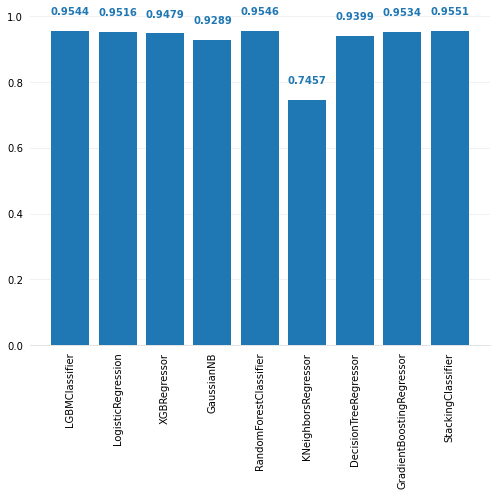

In [25]:
if test_pipeline:
    fig, ax = plt.subplots(figsize=(7,7))

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=M_name,
        height=M_auc_score,
        tick_label=M_name
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    bar_color = bars[0].get_facecolor()
    plt.xticks(rotation=90)

    for bar in bars:
        ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.05,
          round(bar.get_height(), 4),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
        )

    fig.tight_layout()

## Setup Parameters With GridSearchCV

In [26]:
select_classifier = clf2
select_classifier.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

AUC : 0.82639 +/- 0.00612 {'C': 0.001, 'max_iter': 100}
AUC : 0.82639 +/- 0.00612 {'C': 0.001, 'max_iter': 150}
AUC : 0.82639 +/- 0.00612 {'C': 0.001, 'max_iter': 50}
AUC : 0.90657 +/- 0.00328 {'C': 0.01, 'max_iter': 100}
AUC : 0.90657 +/- 0.00328 {'C': 0.01, 'max_iter': 150}
AUC : 0.90657 +/- 0.00328 {'C': 0.01, 'max_iter': 50}
AUC : 0.94524 +/- 0.00157 {'C': 0.1, 'max_iter': 100}
AUC : 0.94524 +/- 0.00157 {'C': 0.1, 'max_iter': 150}
AUC : 0.94527 +/- 0.00157 {'C': 0.1, 'max_iter': 50}
AUC : 0.95163 +/- 0.00069 {'C': 1, 'max_iter': 100}
AUC : 0.95173 +/- 0.00067 {'C': 1, 'max_iter': 150}
AUC : 0.95028 +/- 0.00151 {'C': 1, 'max_iter': 50}
AUC : 0.95194 +/- 0.00022 {'C': 10, 'max_iter': 100}
AUC : 0.95136 +/- 0.00030 {'C': 10, 'max_iter': 150}
AUC : 0.95001 +/- 0.00101 {'C': 10, 'max_iter': 50}

Best parameters: {'C': 10, 'max_iter': 100}

############################################################
####  GridSearchCV
############################################################ 

######

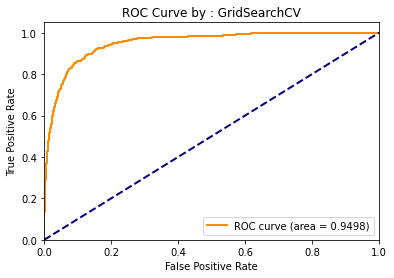

In [27]:
if Setup_Parameters:

    X_train = train_coded.drop('target',axis=1).iloc[:,1:]
    y_train = train_coded['target']

    params = dict(
        C = [0.001, 0.01, 0.1, 1, 10],
        max_iter = [100,150,50]
    )

    grid = GridSearchCV(estimator=select_classifier,
                        param_grid=params, 
                        cv=FOLDS,
                        scoring='roc_auc',
                        refit='AUC',
                        n_jobs = -1)

    grid.fit(X_train, y_train)

    for r, _ in enumerate(grid.cv_results_['mean_test_score']):
        print("AUC : %0.5f +/- %0.5f %r"
              % (grid.cv_results_['mean_test_score'][r],
                 grid.cv_results_['std_test_score'][r] / 2.0,
                 grid.cv_results_['params'][r]))

    print(f'\nBest parameters: {grid.best_params_}')

    oof, submission, auc_score, model_name = crossValidate(grid,X=train_coded,X_test=test_coded,FOLDS=FOLDS,SEED=SEED,show_roc_curve=True)

## Training and Predictions


############################################################
####  LGBMClassifier
############################################################ 

############################################################ 

FOLD :  0
Train TFrecords :  [ 6 11  1 14  9  3 13 12  8  2]
Validation TFrecords :  [ 0 10  4  5  7]
Train AUC :  0.9685172425992854
Val AUC :  0.9509630733264642

Number of Pesudo Labeled Data added :  1998
target_label = 1 :  54
target_label = 0 :  1944
Pesudo Train AUC :  0.9612131413491898
Pesudo Val AUC :  0.9520548914231297


############################################################ 

FOLD :  1
Train TFrecords :  [ 0  6 14 10  4 13 12  5  2  7]
Validation TFrecords :  [11  1  9  3  8]
Train AUC :  0.9661900640504348
Val AUC :  0.9582532575338332

Number of Pesudo Labeled Data added :  2443
target_label = 1 :  91
target_label = 0 :  2352
Pesudo Train AUC :  0.9596327531075959
Pesudo Val AUC :  0.9577403411935786


##########################################################

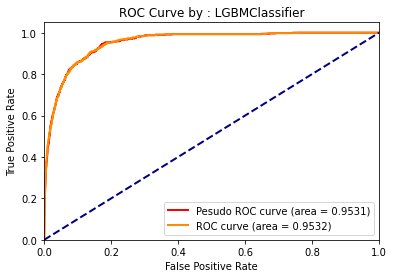


############################################################
####  LogisticRegression
############################################################ 

############################################################ 

FOLD :  0
Train TFrecords :  [ 6 11  1 14  9  3 13 12  8  2]
Validation TFrecords :  [ 0 10  4  5  7]
Train AUC :  0.9512679872130906
Val AUC :  0.9484879441426253

Number of Pesudo Labeled Data added :  1329
target_label = 1 :  69
target_label = 0 :  1260
Pesudo Train AUC :  0.9443429145368957
Pesudo Val AUC :  0.9454281214874486


############################################################ 

FOLD :  1
Train TFrecords :  [ 0  6 14 10  4 13 12  5  2  7]
Validation TFrecords :  [11  1  9  3  8]
Train AUC :  0.9517251068798068
Val AUC :  0.956686958125807

Number of Pesudo Labeled Data added :  1575
target_label = 1 :  101
target_label = 0 :  1474
Pesudo Train AUC :  0.9482988969208511
Pesudo Val AUC :  0.9553295625238073


######################################################

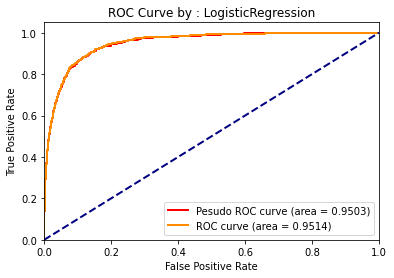


############################################################
####  GaussianNB
############################################################ 

############################################################ 

FOLD :  0
Train TFrecords :  [ 6 11  1 14  9  3 13 12  8  2]
Validation TFrecords :  [ 0 10  4  5  7]
Train AUC :  0.9256070993611942
Val AUC :  0.9238544691363808

Number of Pesudo Labeled Data added :  648
target_label = 1 :  519
target_label = 0 :  129
Pesudo Train AUC :  0.9605146793848778
Pesudo Val AUC :  0.9338989029130761


############################################################ 

FOLD :  1
Train TFrecords :  [ 0  6 14 10  4 13 12  5  2  7]
Validation TFrecords :  [11  1  9  3  8]
Train AUC :  0.9251242332535606
Val AUC :  0.9395189941952532

Number of Pesudo Labeled Data added :  758
target_label = 1 :  606
target_label = 0 :  152
Pesudo Train AUC :  0.9571287133805135
Pesudo Val AUC :  0.9346056820876966


############################################################ 

F

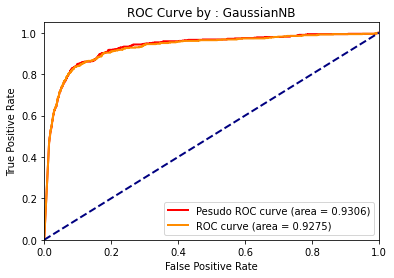


############################################################
####  RandomForestClassifier
############################################################ 

############################################################ 

FOLD :  0
Train TFrecords :  [ 6 11  1 14  9  3 13 12  8  2]
Validation TFrecords :  [ 0 10  4  5  7]
Train AUC :  0.9675517481859128
Val AUC :  0.955173988385163

Number of Pesudo Labeled Data added :  1948
target_label = 1 :  55
target_label = 0 :  1893
Pesudo Train AUC :  0.9595161326449907
Pesudo Val AUC :  0.9540872927594604


############################################################ 

FOLD :  1
Train TFrecords :  [ 0  6 14 10  4 13 12  5  2  7]
Validation TFrecords :  [11  1  9  3  8]
Train AUC :  0.9646955982752078
Val AUC :  0.958827743000405

Number of Pesudo Labeled Data added :  2406
target_label = 1 :  92
target_label = 0 :  2314
Pesudo Train AUC :  0.959625732729077
Pesudo Val AUC :  0.9593418571835838


#####################################################

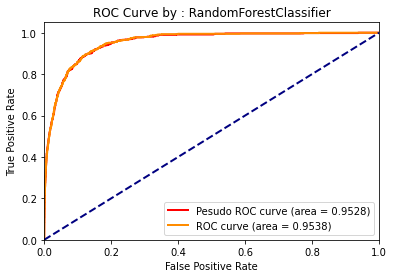


############################################################
####  DecisionTreeRegressor
############################################################ 

############################################################ 

FOLD :  0
Train TFrecords :  [ 6 11  1 14  9  3 13 12  8  2]
Validation TFrecords :  [ 0 10  4  5  7]
Train AUC :  0.9606944651822962
Val AUC :  0.9486555221212688

Number of Pesudo Labeled Data added :  1961
target_label = 1 :  77
target_label = 0 :  1884
Pesudo Train AUC :  0.9551963741552827
Pesudo Val AUC :  0.9486677184807044


############################################################ 

FOLD :  1
Train TFrecords :  [ 0  6 14 10  4 13 12  5  2  7]
Validation TFrecords :  [11  1  9  3  8]
Train AUC :  0.9538821863116397
Val AUC :  0.953569931267773

Number of Pesudo Labeled Data added :  2919
target_label = 1 :  96
target_label = 0 :  2823
Pesudo Train AUC :  0.9495233121865941
Pesudo Val AUC :  0.9560966611326323


####################################################

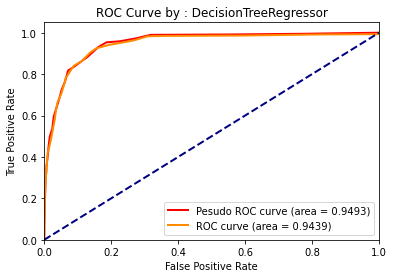


############################################################
####  GradientBoostingRegressor
############################################################ 

############################################################ 

FOLD :  0
Train TFrecords :  [ 6 11  1 14  9  3 13 12  8  2]
Validation TFrecords :  [ 0 10  4  5  7]
Train AUC :  0.971387940944195
Val AUC :  0.9454642227113775

Number of Pesudo Labeled Data added :  1898
target_label = 1 :  56
target_label = 0 :  1842
Pesudo Train AUC :  0.9651691185734292
Pesudo Val AUC :  0.9437950289590359


############################################################ 

FOLD :  1
Train TFrecords :  [ 0  6 14 10  4 13 12  5  2  7]
Validation TFrecords :  [11  1  9  3  8]
Train AUC :  0.9670435172169428
Val AUC :  0.9584868369041031

Number of Pesudo Labeled Data added :  2331
target_label = 1 :  94
target_label = 0 :  2237
Pesudo Train AUC :  0.9656611686755481
Pesudo Val AUC :  0.957828262864234


#################################################

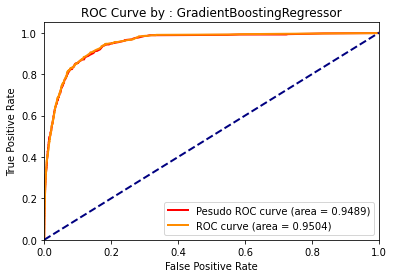


############################################################
####  StackingClassifier
############################################################ 

############################################################ 

FOLD :  0
Train TFrecords :  [ 6 11  1 14  9  3 13 12  8  2]
Validation TFrecords :  [ 0 10  4  5  7]
Train AUC :  0.9692612867382288
Val AUC :  0.9522561313538154

Number of Pesudo Labeled Data added :  1220
target_label = 1 :  64
target_label = 0 :  1156
Pesudo Train AUC :  0.9633972895299199
Pesudo Val AUC :  0.9532796498376421


############################################################ 

FOLD :  1
Train TFrecords :  [ 0  6 14 10  4 13 12  5  2  7]
Validation TFrecords :  [11  1  9  3  8]
Train AUC :  0.9666603255187156
Val AUC :  0.9589642970937935

Number of Pesudo Labeled Data added :  2043
target_label = 1 :  97
target_label = 0 :  1946
Pesudo Train AUC :  0.9615429350862439
Pesudo Val AUC :  0.9591976368954787


######################################################

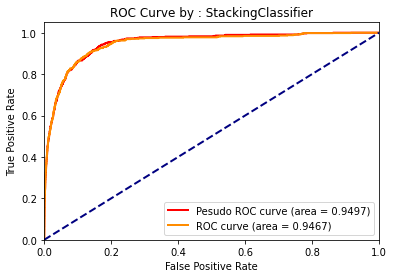

In [28]:
M_name = []
M_auc_score = []
for CLF in [clf1,clf2,clf4,clf5,clf10,clf11,SCF]:
    if pesudo_label:
        oof, submission, auc_score, model_name, \
        pesudo_oof, pesudo_submission, pesudo_auc_score, pesudo_model_name = crossValidate(CLF,X=train_coded,
                                                                                           X_test=test_coded,
                                                                                           FOLDS=FOLDS,SEED=SEED,
                                                                                           show_roc_curve=True,
                                                                                           pesudo_label=True)
    else:
        oof, submission, auc_score, model_name = crossValidate(CLF,X=train_coded,X_test=test_coded,FOLDS=FOLDS,SEED=SEED,show_roc_curve=True,pesudo_label=False)
    
    oof.to_csv(f'oof_{model_name}_{auc_score:0.4f}.csv',index=False)
    submission.to_csv(f'submission_{model_name}_{auc_score:0.4f}.csv',index=False)
    M_name.append(model_name)
    M_auc_score.append(auc_score)
    
    if pesudo_label:
        pesudo_oof.to_csv(f'Pesudo_oof_{model_name}_{pesudo_auc_score:0.4f}.csv',index=False)
        pesudo_submission.to_csv(f'Pesudo_submission_{model_name}_{pesudo_auc_score:0.4f}.csv',index=False)
        M_name.append(pesudo_model_name)
        M_auc_score.append(pesudo_auc_score)

## Classifier Performance

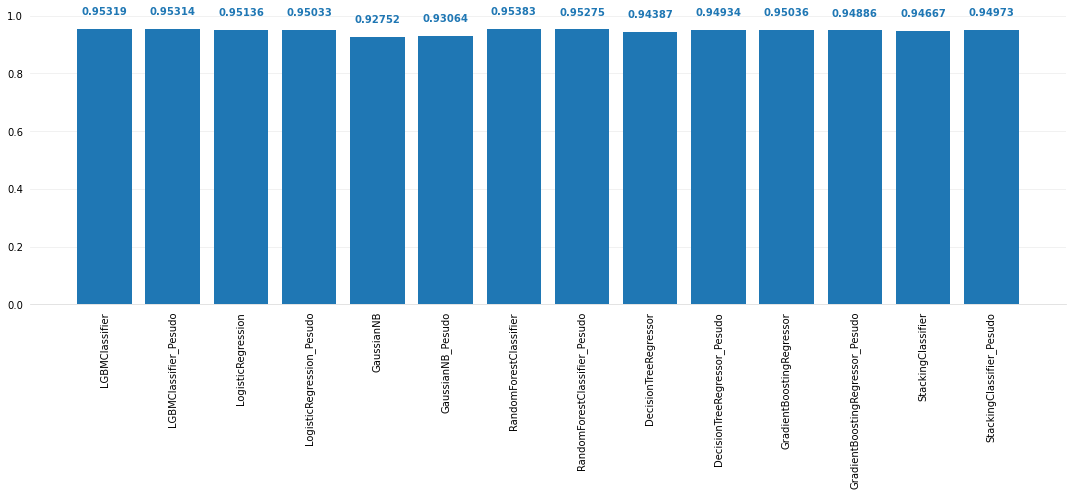

In [29]:
fig, ax = plt.subplots(figsize=(15,7))

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=M_name,
    height=M_auc_score,
    tick_label=M_name
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()
plt.xticks(rotation=90)

for bar in bars:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.05,
      round(bar.get_height(), 5),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
    )

fig.tight_layout()